----

Estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

In [41]:
data_company=pd.read_csv('/datasets/logs_exp_us.csv',sep='\s+')

In [42]:
data_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [43]:
data_company.head(5)




,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [44]:
print(data_company.isna().sum())

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


In [45]:
data_company.columns=['event_name','device_id_hash','Event_time_stamp','exp_id']

In [46]:
data_company['event_hour']=pd.to_datetime(data_company['Event_time_stamp'],unit='s')
data_company['event_date']=data_company['event_hour'].dt.date


In [47]:
print(data_company.head(10))

                event_name       device_id_hash  Event_time_stamp  exp_id  \
0         MainScreenAppear  4575588528974610257        1564029816     246   
1         MainScreenAppear  7416695313311560658        1564053102     246   
2  PaymentScreenSuccessful  3518123091307005509        1564054127     248   
3         CartScreenAppear  3518123091307005509        1564054127     248   
4  PaymentScreenSuccessful  6217807653094995999        1564055322     248   
5         CartScreenAppear  6217807653094995999        1564055323     248   
6       OffersScreenAppear  8351860793733343758        1564066242     246   
7         MainScreenAppear  5682100281902512875        1564085677     246   
8         MainScreenAppear  1850981295691852772        1564086702     247   
9         MainScreenAppear  5407636962369102641        1564112112     246   

           event_hour  event_date  
0 2019-07-25 04:43:36  2019-07-25  
1 2019-07-25 11:11:42  2019-07-25  
2 2019-07-25 11:28:47  2019-07-25  
3 2019-0

In [48]:
event=data_company.shape[0]
print(event)

244126


En los registros hay 244126 eventos

In [49]:
event_unique=data_company['device_id_hash'].nunique()
print(event_unique)


7551


El total de los usuarios son 7551 teniendo en cuenta los registros

In [50]:
mean_per_user=data_company['device_id_hash'].value_counts()
print(mean_per_user.mean())

32.33028737915508


El promedio de evento por usuario es 32

In [51]:
date_min_max=data_company['event_date'].min(),data_company['event_date'].max()
print(date_min_max)

(datetime.date(2019, 7, 25), datetime.date(2019, 8, 7))


Los datos cubren el periodo entre Julio y Agosto de 2019, la fecha minima de eventos es el 25 de julio de 2019 y la fecha maxima es el 07 de Agosto de 2019

<AxesSubplot:>

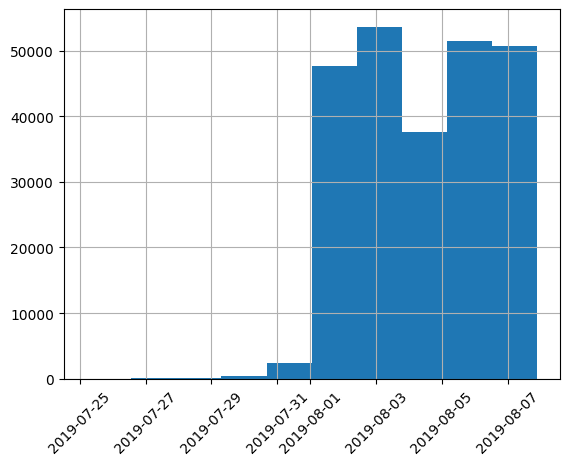

In [52]:
plt.xticks(rotation=45)
data_company['event_hour'].hist()

De acuerdo al histograma la mayoria de eventos se presentan del 31 de julio al 07 de agosto de 2019

In [53]:
start_date=pd.to_datetime('2019-07-31')
end_date=pd.to_datetime('2019-08-07')

data_filter=data_company[(data_company['event_date']>=start_date)&(data_company['event_date']<=end_date)]
print(data_filter)

                event_name       device_id_hash  Event_time_stamp  exp_id  \
797       MainScreenAppear  3670880358399219515        1564535506     247   
798     OffersScreenAppear  3799109751993694887        1564536064     248   
799               Tutorial  1126021718529336913        1564536731     247   
800       MainScreenAppear  4293428370257583636        1564539558     248   
801       MainScreenAppear  4567464647598975872        1564540410     247   
...                    ...                  ...               ...     ...   
244121    MainScreenAppear  4599628364049201812        1565212345     247   
244122    MainScreenAppear  5849806612437486590        1565212439     246   
244123    MainScreenAppear  5746969938801999050        1565212483     246   
244124    MainScreenAppear  5746969938801999050        1565212498     246   
244125  OffersScreenAppear  5746969938801999050        1565212517     246   

                event_hour  event_date  
797    2019-07-31 01:11:46  2019-0

In [54]:
total= (data_company['device_id_hash'].nunique())
last= (data_filter['device_id_hash'].nunique())
user_lost= total - last
event_total=len(data_company['event_name'])
event_last=len(data_filter['event_name'])
event_lost=(event_total)-(event_last)


print(f"los usuarios perdidos son:",user_lost)
print(f"los eventos perdidos son:",event_lost)

los usuarios perdidos son: 9
los eventos perdidos son: 797


Se realiza filtro y se dejan a partir de 31 de julio y se cuenta con los usuarios de los tres grupos experimentales 

In [55]:
event_frequency=data_filter.groupby('event_name').agg({'device_id_hash': ['count']}).sort_values(by=('device_id_hash','count'),ascending=False)
print(event_frequency)

                        device_id_hash
                                 count
event_name                            
MainScreenAppear                118681
OffersScreenAppear               46724
CartScreenAppear                 42623
PaymentScreenSuccessful          34253
Tutorial                          1048


En los registros hay 5 eventos, El MainScreen Appear es la primera etapa.

In [56]:
user_per_event=data_filter['event_name'].value_counts().reset_index()
user_per_event.columns=['event_name','user_count']
total_user=data_filter['device_id_hash'].nunique()
user_per_event['proportion']=user_per_event['user_count']/total_user
print(user_per_event)

                event_name  user_count  proportion
0         MainScreenAppear      118681   15.736012
1       OffersScreenAppear       46724    6.195174
2         CartScreenAppear       42623    5.651419
3  PaymentScreenSuccessful       34253    4.541634
4                 Tutorial        1048    0.138955


Se visualizan la cantidad de usuarios que realizaron estas acciones, y su proporcion respectiva.

In [57]:
event_frequency_user=data_filter.groupby('event_name').agg({'device_id_hash': ['nunique']}).sort_values(by=('device_id_hash','nunique'),ascending=False)
event_frequency_user=event_frequency_user.reset_index()
print(event_frequency_user)

                event_name device_id_hash
                                  nunique
0         MainScreenAppear           7429
1       OffersScreenAppear           4606
2         CartScreenAppear           3742
3  PaymentScreenSuccessful           3542
4                 Tutorial            845


El orden en el que ocurrieron las acciones es: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful y Tutorial. No necesariamente todos los usuarios llevan la misma secuencia.

In [58]:
user_event_filter= data_filter.pivot_table(index='device_id_hash',columns='event_name',values='event_hour',aggfunc='min')
step_1 =~user_event_filter['MainScreenAppear'].isna()
step_2 =step_1 &(user_event_filter['OffersScreenAppear']>user_event_filter['MainScreenAppear'])
step_3 = step_2 & (user_event_filter['CartScreenAppear']>user_event_filter['OffersScreenAppear'])
step_4 = step_3 & (user_event_filter['PaymentScreenSuccessful']>user_event_filter['CartScreenAppear'])
step_5=  step_4 & (user_event_filter['Tutorial']>user_event_filter['PaymentScreenSuccessful'])



In [59]:
n_MainScreenAppear = user_event_filter[step_1].shape[0]
n_OffersScreenAppear = user_event_filter[step_2].shape[0]
n_CartScreenAppear = user_event_filter[step_3].shape[0]
n_PaymentScreenSuccessful=  user_event_filter[step_4].shape[0]
n_Tutorial=  user_event_filter[step_5].shape[0]

print('Inicio', n_MainScreenAppear)
print('Oferta:', n_OffersScreenAppear)
print('Agrega al carro:', n_CartScreenAppear)
print('Pagado:', n_PaymentScreenSuccessful)
print('Tutorial:',n_Tutorial)


Inicio 7429
Oferta: 4116
Agrega al carro: 1672
Pagado: 453
Tutorial: 1


De acuerdo al embudo se visualiza la secuencia de como van pasando los usuarios por cada una de las etapas..

In [60]:
event_proportion_user=data_filter.groupby('event_name').agg({'device_id_hash': ['nunique']}).sort_values(by=('device_id_hash','nunique'),ascending=False)
event_proportion_user=event_proportion_user.reset_index()
event_proportion_user.columns=['event_name','cant_user']
total_user=data_filter['device_id_hash'].nunique()
event_proportion_user['proportion']=event_proportion_user['cant_user']/total_user
print(event_proportion_user)

                event_name  cant_user  proportion
0         MainScreenAppear       7429    0.985017
1       OffersScreenAppear       4606    0.610713
2         CartScreenAppear       3742    0.496155
3  PaymentScreenSuccessful       3542    0.469637
4                 Tutorial        845    0.112039


In [61]:
percent_user_MainScreenAppear = (n_MainScreenAppear/n_MainScreenAppear)*100
percent_user_OffersScreenAppear = (n_OffersScreenAppear /n_MainScreenAppear)*100
percent_user_CartScreenAppear = (n_CartScreenAppear/n_OffersScreenAppear)*100
percent_user_PaymentScreenSuccessful= (n_PaymentScreenSuccessful/n_CartScreenAppear)*100

print('Inicio', f"{percent_user_MainScreenAppear:.1f}%")
print('Oferta:',f" {percent_user_OffersScreenAppear:.1f}%")
print('Agrega al carro:',f"{percent_user_CartScreenAppear:.1f}%")
print('Pagado:', f"{percent_user_PaymentScreenSuccessful:.1f}%")


Inicio 100.0%
Oferta:  55.4%
Agrega al carro: 40.6%
Pagado: 27.1%


Con lo anterior podemos determinar que en la etapa en la que se perdieron mas ausuarios fue en OffersScreenAppear

 En la etapa que se pierden mas usuarios es en OfferScreenAppear.

In [62]:
n_MainScreenAppear = user_event_filter[step_1].shape[0]
n_PaymentScreenSuccessful=  user_event_filter[step_4].shape[0]
percent_event=((n_PaymentScreenSuccessful/n_MainScreenAppear)*100)
print(f"El porcentaje de Usuarios que van de la primera etapa a el pago es del: {percent_event:.2f} %")

El porcentaje de Usuarios que van de la primera etapa a el pago es del: 6.10 %


In [63]:
usuarios_group=data_filter.groupby('exp_id')['device_id_hash'].nunique()
print(usuarios_group)

exp_id
246    2485
247    2517
248    2540
Name: device_id_hash, dtype: int64


En el grupo 246 hay 2485 usuarios, en el 247 2517 y en el 248 2540 usuarios.

In [64]:
total_usuarios_246=data_filter[data_filter['exp_id']==246]['device_id_hash'].nunique()
total_usuarios_247=data_filter[data_filter['exp_id']==247]['device_id_hash'].nunique()
conversion_246=data_filter[(data_filter['exp_id']==246)&(data_filter['event_name']=='PaymentScreenSuccessful')]['device_id_hash'].nunique()
conversion_247=data_filter[(data_filter['exp_id']==247)&(data_filter['event_name']=='PaymentScreenSuccessful')]['device_id_hash'].nunique()
tasa_conversion_246=conversion_246/total_usuarios_246
tasa_conversion_247=conversion_247/total_usuarios_247


In [65]:
convert=[conversion_246,conversion_247]
nobs=[total_usuarios_246,total_usuarios_247]
stat,p_value=proportions_ztest(convert,nobs)
print(f"valor z:{stat}")
print(f"valor p:{p_value}")
alpha=0.05
if (p_value<alpha):# escribe tu código aquí
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")


valor z:1.5887871692043074
valor p:0.11210845100173074
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


No hay diferencia significativa entre los dos grupos

El evento mas popular con mayor participacion para los dos grupo es el MainScreenAppear.

In [66]:
def statiscal(data_filter):
    result=[]
    events=data_filter['event_name'].unique()
    for event in events:
        total_usuarios_246=data_filter[data_filter['exp_id']==246]['device_id_hash'].nunique()
        total_usuarios_247=data_filter[data_filter['exp_id']==247]['device_id_hash'].nunique()
        conversion_246=data_filter[(data_filter['exp_id']==246)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        conversion_247=data_filter[(data_filter['exp_id']==247)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        tasa_conversion_246=conversion_246/total_usuarios_246
        tasa_conversion_247=conversion_247/total_usuarios_247
        convert=[conversion_246,conversion_247]
        nobs=[total_usuarios_246,total_usuarios_247]
        stat,p_value=proportions_ztest(convert,nobs)
        result.append({'event_name':event,'p_value':p_value})
     
    return pd.DataFrame(result)


Prueba_246_247=statiscal(data_filter)
alpha=0.05
Prueba_246_247['significancia']=Prueba_246_247['p_value']<alpha
Prueba_246_247['significancia']=Prueba_246_247['significancia'].apply(lambda x:"significativa" if x else "No significativa")

print(Prueba_246_247)

                            
    
    

                event_name   p_value     significancia
0         MainScreenAppear  0.586878  No significativa
1       OffersScreenAppear  0.274351  No significativa
2                 Tutorial  0.879161  No significativa
3  PaymentScreenSuccessful  0.112108  No significativa
4         CartScreenAppear  0.213061  No significativa


Para ninguno de los eventoses significativa la diferencia.

In [67]:
def statiscal(data_filter):
    result=[]
    events=data_filter['event_name'].unique()
    for event in events:
        total_usuarios_246=data_filter[data_filter['exp_id']==246]['device_id_hash'].nunique()
        total_usuarios_248=data_filter[data_filter['exp_id']==248]['device_id_hash'].nunique()
        conversion_246=data_filter[(data_filter['exp_id']==246)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        conversion_248=data_filter[(data_filter['exp_id']==248)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        tasa_conversion_246=conversion_246/total_usuarios_246
        tasa_conversion_248=conversion_248/total_usuarios_248
        convert=[conversion_246,conversion_248]
        nobs=[total_usuarios_246,total_usuarios_248]
        stat,p_value=proportions_ztest(convert,nobs)
        result.append({'event_name':event,'p_value':p_value})
     
    return pd.DataFrame(result)


Prueba_246_248=statiscal(data_filter)
alpha=0.05
Prueba_246_248['significancia']=Prueba_246_248['p_value']<alpha
Prueba_246_248['significancia']=Prueba_246_248['significancia'].apply(lambda x:"significativa" if x else "No significativa")

print(Prueba_246_248)


                event_name   p_value     significancia
0         MainScreenAppear  0.341286  No significativa
1       OffersScreenAppear  0.226997  No significativa
2                 Tutorial  0.923947  No significativa
3  PaymentScreenSuccessful  0.223522  No significativa
4         CartScreenAppear  0.099417  No significativa


Para ninguno de los eventoses significativa la diferencia.

In [68]:
def statiscal(data_filter):
    result=[]
    events=data_filter['event_name'].unique()
    for event in events:
        total_usuarios_247=data_filter[data_filter['exp_id']==247]['device_id_hash'].nunique()
        total_usuarios_248=data_filter[data_filter['exp_id']==248]['device_id_hash'].nunique()
        conversion_247=data_filter[(data_filter['exp_id']==247)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        conversion_248=data_filter[(data_filter['exp_id']==248)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        tasa_conversion_247=conversion_246/total_usuarios_247
        tasa_conversion_248=conversion_248/total_usuarios_248
        convert=[conversion_247,conversion_248]
        nobs=[total_usuarios_247,total_usuarios_248]
        stat,p_value=proportions_ztest(convert,nobs)
        result.append({'event_name':event,'p_value':p_value})
     
    return pd.DataFrame(result)


Prueba_247_248=statiscal(data_filter)
alpha=0.05
Prueba_247_248['significancia']=Prueba_247_248['p_value']<alpha
Prueba_247_248['significancia']=Prueba_247_248['significancia'].apply(lambda x:"significativa" if x else "No significativa")

print(Prueba_246_248)
            
        

                event_name   p_value     significancia
0         MainScreenAppear  0.341286  No significativa
1       OffersScreenAppear  0.226997  No significativa
2                 Tutorial  0.923947  No significativa
3  PaymentScreenSuccessful  0.223522  No significativa
4         CartScreenAppear  0.099417  No significativa


Para ninguno de los eventoses significativa la diferencia.

In [69]:
def statiscal(data_filter):
    result=[]
    events=data_filter['event_name'].unique()
    for event in events:
        total_usuarios_246=data_filter[data_filter['exp_id']==246]['device_id_hash'].nunique()
        total_usuarios_248=data_filter[data_filter['exp_id']==248]['device_id_hash'].nunique()
        conversion_246=data_filter[(data_filter['exp_id']==246)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        conversion_248=data_filter[(data_filter['exp_id']==248)&(data_filter['event_name']==event)]['device_id_hash'].nunique()
        tasa_conversion_246=conversion_246/total_usuarios_246
        tasa_conversion_248=conversion_248/total_usuarios_248
        convert=[conversion_246,conversion_248]
        nobs=[total_usuarios_246,total_usuarios_248]
        stat,p_value=proportions_ztest(convert,nobs)
        result.append({'event_name':event,'p_value':p_value})
     
    return pd.DataFrame(result)


Prueba_246_248=statiscal(data_filter)
alpha=0.1
Prueba_246_248['significancia']=Prueba_246_248['p_value']<alpha
Prueba_246_248['significancia']=Prueba_246_248['significancia'].apply(lambda x:"significativa" if x else "No significativa")

print(Prueba_246_248)


                event_name   p_value     significancia
0         MainScreenAppear  0.341286  No significativa
1       OffersScreenAppear  0.226997  No significativa
2                 Tutorial  0.923947  No significativa
3  PaymentScreenSuccessful  0.223522  No significativa
4         CartScreenAppear  0.099417     significativa


Al cambiar el valor el ultimo evento arroja como diferencia significativa.